In [196]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# you can comment these lines out usually
# if your Jupyter kernel dies after training
# this can help to fix it
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [197]:
df = pd.read_csv('coin_Aave.csv')

<h3>Used crypto currency dataset, predict 'Volume' and 'High'</h3>

In [198]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Aave,AAVE,2020-10-05 23:59:59,55.112358,49.787900,52.675035,53.219243,0.000000e+00,8.912813e+07
1,2,Aave,AAVE,2020-10-06 23:59:59,53.402270,40.734578,53.291969,42.401599,5.830915e+05,7.101144e+07
2,3,Aave,AAVE,2020-10-07 23:59:59,42.408314,35.970690,42.399947,40.083976,6.828342e+05,6.713004e+07
3,4,Aave,AAVE,2020-10-08 23:59:59,44.902511,36.696057,39.885262,43.764463,1.658817e+06,2.202651e+08
4,5,Aave,AAVE,2020-10-09 23:59:59,47.569533,43.291776,43.764463,46.817744,8.155377e+05,2.356322e+08


In [199]:
df.describe()

,SNo,High,Low,Open,Close,Volume,Marketcap
count,275.000000,275.000000,275.000000,275.000000,275.000000,2.750000e+02,2.750000e+02
mean,138.000000,271.306751,237.736035,254.506688,255.525845,5.023421e+08,3.168639e+09
std,79.529869,173.030432,151.302431,162.067209,161.649917,4.527200e+08,2.066558e+09
min,1.000000,28.433069,25.966155,27.715080,27.715084,0.000000e+00,6.713004e+07
25%,69.500000,85.078206,76.038104,80.557436,81.100120,2.400042e+08,9.736814e+08
50%,138.000000,306.990536,274.746278,292.268571,295.089229,3.693558e+08,3.697227e+09
75%,206.500000,407.518278,361.685763,382.275163,382.579255,6.204643e+08,4.784464e+09
max,275.000000,666.864979,565.749887,629.231665,632.266488,2.838573e+09,8.063210e+09


In [200]:
df = df.drop(["Name", "Symbol"], axis=1)
# useless columns

In [201]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [202]:
# scale only relevant variables
num_cols = ["Volume", "High"]
df[num_cols] = scaler.fit_transform(df[num_cols])

In [203]:
df = df.drop(["Date", "Close", "Low", "Open", "Marketcap"], axis=1)
# drop columns that are not needed now

In [204]:
df.head()

,SNo,High,Volume
0,1,0.041789,0.000000
1,2,0.039110,0.000205
2,3,0.021890,0.000241
3,4,0.025797,0.000584
4,5,0.029974,0.000287


In [205]:
df = pd.melt(df, id_vars=["SNo"], value_vars=["Volume", "High"],
             var_name="class", value_name="price")
# melted data

In [206]:
df.head(10)

,SNo,class,price
0,1,Volume,0.000000
1,2,Volume,0.000205
2,3,Volume,0.000241
3,4,Volume,0.000584
4,5,Volume,0.000287
5,6,Volume,0.000379
6,7,Volume,0.000244
7,8,Volume,0.000477
8,9,Volume,0.000488
9,10,Volume,0.001104


In [207]:
df['class'] = df['class'].replace({"High": 0, "Volume": 1})
# replace classes with numbers

In [208]:
class_names = np.array(["High", "Volume"])
num_classes = len(class_names)
classes = [0, 1]
# class names and their corresponding numbers

In [209]:
df_class_1 = df[df['class'] == 0]
df_class_2 = df[df['class'] == 1]

# combine into a list for easier iteration
# WHEN WE DO THE TIMESTEP SPLIT
splitted_dfs = [df_class_1, df_class_2] 

In [210]:
df_class_1['class'].value_counts()
# 275 rows of 0

class
0    275
Name: count, dtype: int64

In [211]:
df_class_2['class'].value_counts()
# 275 rows of 1

class
1    275
Name: count, dtype: int64

In [212]:
max_size = 270
time_step_size = 18

# x_total is going to be the signal 
x_total = []
y_total = []

# built x_total and y_total for all categories (2 at this point)
for category in classes:
    # we will start cutting the original signal data
    # starting from index 0
    index_cutoff = 0

    while index_cutoff / max_size < 1:
        timestep = []

        # take a slice of 50 points, starting from cutoff until cutoff + 50
        slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + time_step_size]

        #normalize the slice
        slice['price'] = (slice['price'] - slice['price'].min()) / (slice['price'].max() - slice['price'].min())

        # take a slice of selected category / signal type
        # and place it in x_total and y_total
        x_total.append(list(slice['price']))
        y_total.append(category)

        # after each slicing operation, increase the cutoff
        # by 50 (step size), otherwise we get an infinite
        index_cutoff += time_step_size

C:\Users\Roman\AppData\Local\Temp\ipykernel_20072\1069560813.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice['price'] = (slice['price'] - slice['price'].min()) / (slice['price'].max() - slice['price'].min())


In [213]:
slice = splitted_dfs[category].iloc[index_cutoff:index_cutoff + time_step_size]

In [214]:
# 30 signals, 15 for each category
len(x_total)

30

In [215]:
# 30 signals, 15 for each category
len(y_total)

30

In [216]:
y_total[5]

0

In [217]:
len(x_total[0])

18

In [218]:
import random
zipped = list(zip(x_total, y_total))
random.shuffle(zipped)
x_total, y_total = zip(*zipped)

In [219]:
x_total

([0.4740214086596411,
  0.40613255506437307,
  0.0,
  0.2884225862409099,
  0.38832910903516604,
  0.5123602867427045,
  0.639505350019036,
  0.8842335525305385,
  0.8686441064292583,
  0.936066124208589,
  1.0,
  0.7658384960819882,
  0.6668824838248969,
  0.6274578643415936,
  0.6544834919849648,
  0.3473408482261139,
  0.24293661969058405,
  0.4011150724855012],
 [0.8280756086276545,
  0.695094497360269,
  1.0,
  0.8498597976833085,
  0.9072331163161634,
  0.9026025797888508,
  0.7112024379966629,
  0.6284433962219067,
  0.5328312388027746,
  0.4061727732628163,
  0.5272293656092426,
  0.3423677111606038,
  0.6022396384215508,
  0.3822077459578638,
  0.34380871367205634,
  0.09713023165499962,
  0.10436275284482627,
  0.0],
 [0.5990906612306075,
  0.29142505462708884,
  0.6951182808926659,
  1.0,
  0.975731250568618,
  0.34934295169396284,
  0.28237789026138765,
  0.15632338356561376,
  0.0,
  0.6786534518761935,
  0.66007783539268,
  0.4006157824378275,
  0.5603823599710944,
  0.28

In [220]:
x_total = np.array(x_total)
y_total = np.array(y_total)

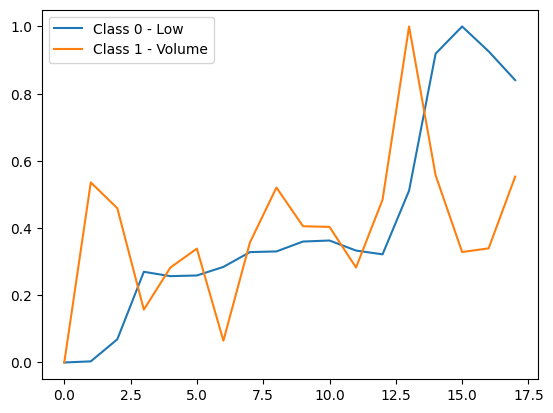

In [221]:
test_signal_index = 2

c_x_train = x_total[y_total == 0]
plt.plot(c_x_train[test_signal_index], label="Class 0 - Low")

c_x_train = x_total[y_total == 1]
plt.plot(c_x_train[test_signal_index], label="Class 1 - Volume")
plt.legend()

In [222]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=0.4, random_state=42)

In [223]:
x_train

array([[0.        , 0.00961684, 0.01126188, 0.02735862, 0.01345054,
        0.01772367, 0.01141554, 0.02234511, 0.02286274, 0.0516623 ,
        0.09702986, 0.8717331 , 0.71479507, 0.66699014, 0.81293099,
        1.        , 0.72290209, 0.90244545],
       [1.        , 0.96327996, 0.4452648 , 0.94283994, 0.56862475,
        0.25317706, 0.39383722, 0.55850723, 0.61519344, 0.04515401,
        0.0872161 , 0.2452267 , 0.30755666, 0.        , 0.20526521,
        0.19955884, 0.19004221, 0.28410308],
       [0.88155337, 0.49990567, 1.        , 0.26995782, 0.26022463,
        0.23281088, 0.16409443, 0.49124227, 0.33349537, 0.45125005,
        0.0886784 , 0.15134143, 0.74246676, 0.0736477 , 0.33131468,
        0.50984261, 0.21880872, 0.        ],
       [0.8679847 , 1.        , 0.528801  , 0.41202834, 0.98694304,
        0.81141803, 0.42346864, 0.31485401, 0.46612745, 0.31572409,
        0.        , 0.31561816, 0.415553  , 0.34479338, 0.08385166,
        0.0944692 , 0.09745763, 0.25343905],
    

In [224]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [225]:
def make_model(input_shape):
    model = keras.Sequential(
        [
            keras.layers.Input(input_shape),

            # one convolutional layer package
            keras.layers.Conv1D(filters=24, kernel_size=5, padding="same", activation="relu"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.6),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Conv1D(filters=48, kernel_size=3, padding="same", activation="relu"),
            keras.layers.Dropout(0.7),
            keras.layers.MaxPooling1D(pool_size=2),
            keras.layers.Conv1D(filters=96, kernel_size=3, padding="same", activation="relu"),
            keras.layers.Dropout(0.8),
            keras.layers.Flatten(),

            # our normal neural network after flattening
            keras.layers.Dense(288, activation="relu"),

            # output layer
            keras.layers.Dense(num_classes, activation="softmax")
        ]
    )
    
    return model


model = make_model(input_shape=x_train.shape[1:])

In [226]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 18, 24)            144       
                                                                 
 batch_normalization_5 (Bat  (None, 18, 24)            96        
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 18, 24)            0         
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 9, 24)             0         
 ng1D)                                                           
                                                                 
 conv1d_16 (Conv1D)          (None, 9, 48)             3504      
                                                                 
 dropout_16 (Dropout)        (None, 9, 48)            

In [227]:
epochs = 800
batch_size = 8

# useful callbacks typically for time series
# or CNN in general
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
]

# usual combination
# this example uses sparse categorical crossentropy
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

# train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(x_test, y_test),
    verbose=1,
)

Epoch 1/800


3/3 [==============================] - 1s 132ms/step - loss: 1.6049 - sparse_categorical_accuracy: 0.6667 - val_loss: 0.7029 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/800
3/3 [==============================] - 0s 42ms/step - loss: 1.2031 - sparse_categorical_accuracy: 0.4444 - val_loss: 0.7015 - val_sparse_categorical_accuracy: 0.4167
Epoch 3/800
3/3 [==============================] - 0s 33ms/step - loss: 1.7614 - sparse_categorical_accuracy: 0.5556 - val_loss: 0.7003 - val_sparse_categorical_accuracy: 0.4167
Epoch 4/800
3/3 [==============================] - 0s 36ms/step - loss: 1.1061 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.4167
Epoch 5/800
3/3 [==============================] - 0s 39ms/step - loss: 1.1097 - sparse_categorical_accuracy: 0.6111 - val_loss: 0.6974 - val_sparse_categorical_accuracy: 0.5833
Epoch 6/800
3/3 [==============================] - 0s 37ms/step - loss: 1.0532 - sparse_categorical_accuracy: 0.6111 - va

<Axes: >

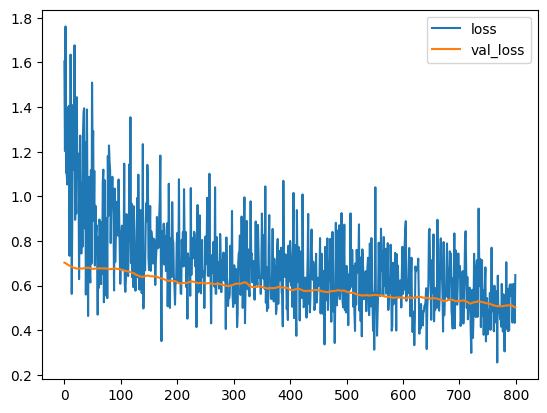

In [228]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()
# val loss does not increase, so no overfitting

<Axes: >

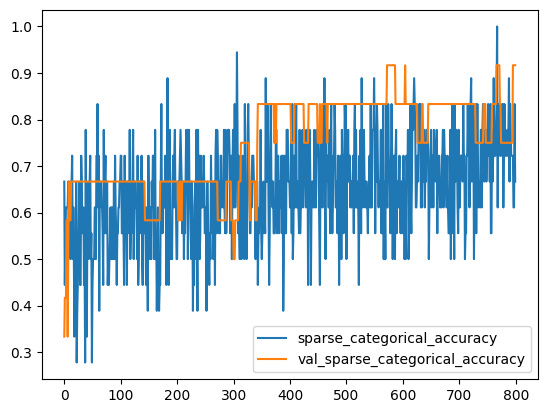

In [229]:
loss_df[['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [230]:
 # load up the best version of the model
model = keras.models.load_model("best_model.keras")

# evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

1/1 [==============================] - 0s 240ms/step - loss: 0.5026 - sparse_categorical_accuracy: 0.9167
Test accuracy 0.9166666865348816
Test loss 0.5026370286941528


In [231]:
 # make predictions and use argmax
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

1/1 [==============================] - 0s 95ms/step


<Axes: >

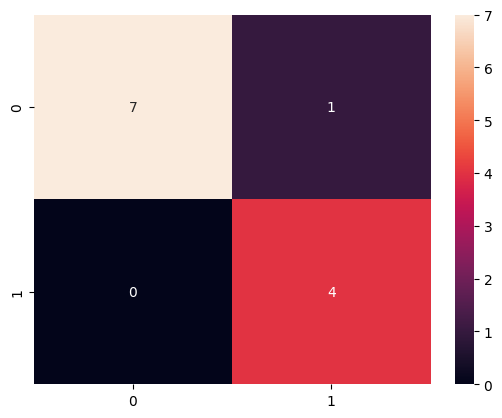

In [232]:
 # confusion matrix
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')

In [233]:
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

# the model is quite good, overall accuracy is 92%

              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.80      1.00      0.89         4

    accuracy                           0.92        12
   macro avg       0.90      0.94      0.91        12
weighted avg       0.93      0.92      0.92        12


Model overall accuracy: 91.67%


In [234]:
roc_auc_score(y_test, model.predict(x_test)[:, 1])
# auc score is 0.94, which is very good

1/1 [==============================] - 0s 32ms/step


0.9375